### Connect notebook with Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Dependencies

In [ ]:
!pip install -r /content/drive/MyDrive/MRCNN-main/Requirements.txt

### Set-GPU on tensorflow

In [ ]:
!pip install tensorflow-gpu==1.15 
import tensorflow as tf
config_ = tf.ConfigProto(device_count = {'GPU': 1})
sess = tf.Session(config=config_)

### Imports

In [2]:
import os
import sys
import random
import math
import re
import time
import json
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw
from skimage.draw import rectangle,polygon
import warnings
warnings.filterwarnings("ignore")

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# run python file into specified directory
%matplotlib inline 
%cd /content/drive/MyDrive/MRCNN-main/Mask_Rcnn

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log


# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/content/drive/MyDrive/MRCNN-main/Mask_Rcnn


Using TensorFlow backend.


... done downloading pretrained model!


### Configuration

In [3]:
class CrackConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to dataset."""
    # Give the configuration a recognizable name
    NAME = "crack"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16

    # Number of classes (including background)
    NUM_CLASSES = 1 + 5  # background + classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 16

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 10

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10

    # view only single instance 
    DETECTION_MAX_INSTANCES = 1
    
config = CrackConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### For Visualization

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Crack-Dataset Class

In [13]:
class CrackDataset(utils.Dataset):
    def load_custom(self, dataset_dir, subset):
        """Load a subset of the custom dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes according to the usecase required to detect
        self.add_class("crack", 1, "Good_situation")
        self.add_class("crack", 2, "Very_little_crack")
        self.add_class("crack", 3, "Meaningfull_crack")
        self.add_class("crack", 4, "Big_crack")
        self.add_class("crack", 5, "Huge_crack_Immediatte_Action_Needed")



        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        # print(annotations['_via_img_metadata'])
        l = list(annotations['_via_img_metadata'].items())
        random.shuffle(l)
        annotations['_via_img_metadata'] = dict(l)
        # print(annotations['_via_img_metadata'])
                
        
        annotations = [annotations['_via_img_metadata'][a] for a in annotations['_via_img_metadata']]

        for ind, a in enumerate(annotations):
            
            polygons = [r['shape_attributes'] for r in annotations[ind]['regions']]
            custom = [s['region_attributes'] for s in annotations[ind]['regions']]

            num_ids=[]
            for n in custom:
                try:
                    if list(n['class'].keys())[0]=='Good_situation':
                        num_ids.append(1)
                    elif list(n['class'].keys())[0]=='Very_little_crack':
                        num_ids.append(2)
                    elif list(n['class'].keys())[0]=='Meaningfull_crack':
                        num_ids.append(3)
                    elif list(n['class'].keys())[0]=='Big_crack':
                        num_ids.append(4)
                    else:
                        num_ids.append(5)
                except Exception as e:
                    pass

            image_path = os.path.join(dataset_dir, annotations[ind]['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            self.add_image(
                "crack",
                image_id=annotations[ind]['filename'], 
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )  

    def load_mask(self, image_id):
        """Generate instance masks for an image.
         Returns:
         masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        

        if image_info["source"] != "crack":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        
        mask = np.zeros([info["height"], info["width"], 3], dtype=np.uint8)
        class_ids=[]
        
        for i in range(len(info['polygons'])):
            x1 = info["polygons"][i]['x']
            x2 = info["polygons"][i]['x']+info["polygons"][i]['width']
            x3 = x2
            x4 = x1
            
            y1 = info["polygons"][i]['y']
            y2 = y1
            y3 = y2 + info["polygons"][i]['height']
            y4 = y3
                
            rr, cc = polygon([y1,y2,y3,y4],[x1,x2,x3,x4])

            mask[rr, cc, 0] = 1
            mask[rr, cc, 1] = 1
            mask[rr, cc, 2] = 1
            
            class_ids.append(info['num_ids'][i]) 
        class_ids = np.array(class_ids[:mask.shape[-1]], dtype=np.int32) if len(class_ids)>=3  else np.array(list(map(int,(list(str(class_ids[0])*mask.shape[-1])))))  
        
        return mask.astype(np.bool), class_ids
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "crack":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

### Training the model

In [14]:
# Training dataset
dataset_train = CrackDataset()
dataset_train.load_custom('/content/drive/MyDrive/MRCNN-main/Dataset','train')
dataset_train.prepare()

# Validation dataset
dataset_val = CrackDataset()
dataset_val.load_custom('/content/drive/MyDrive/MRCNN-main/Dataset','val')
dataset_val.prepare()

In [15]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [16]:
# [info["height"], info["width"],# Which weights to start with?, set base-weights.
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=600, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

### Inference config

In [5]:
class InferenceConfig(CrackConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)


# model_path = os.path.join(ROOT_DIR, ".h5 file name here")

# uncomment below lines when you are training it will auto extract the weights of training which you do.
# model_path = model.find_last()

# Load trained weights
# print("Loading weights from ", model_path)
# model.load_weights(model_path, by_name=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


### Save and Load Models

In [6]:
# save model when you finalize any model
# model.keras_model.save_weights('final_model.h5')
# load model
model.keras_model.load_weights('/content/drive/MyDrive/MRCNN-main/Mask_Rcnn/final_model.h5')

### Show result of image from dataset-val random

In [14]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
# image_id = 15
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)
    
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

### Test-your-Image

Processing 1 images
image                    shape: (227, 227, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -89.70000  max:  150.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  227.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
[4] 1


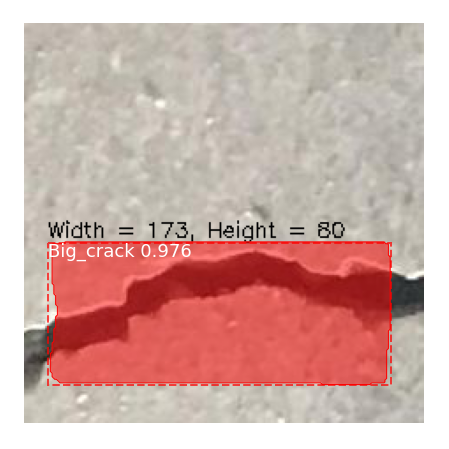

In [7]:
dataset_val_list = ['BG','Good_situation','Very_little_crack','Meaningfull_crack',
               'Big_crack','Huge_crack_Immediatte_Action_Needed']

original_image = skimage.io.imread('/content/drive/MyDrive/MRCNN-main/Dataset/val/big_crack319.jpg')


results = model.detect([original_image], verbose=1)
r = results[0]
def get_height_and_width():
  mask = (r['masks'])
  mask = mask.astype(np.uint8)
  h, w = mask.shape[0:2]
  y1=np.where(mask!=0)[0][0]
  x1=np.where(mask!=0)[1][0]
  y2=np.where(mask!=0)[0][-1]
  x2=np.where(mask!=0)[1][-1]

  width = x2-x1
  height = y2-y1

  return abs(width), abs(height)
width, height = get_height_and_width()
x_min = r['rois'][0][1]
y_min = r['rois'][0][0]
font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 0.4
fontColor              = (0,0,0)
thickness              = 1
lineType               = 0

cv2.putText(original_image,"Width = {}, Height = {}".format(width, height), (x_min, y_min-3),font,
            fontScale,fontColor,thickness,lineType)


print(r['class_ids'],len(r['rois']))

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val_list, r['scores'], ax=get_ax())

### MAP-Score

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.23333334028720856
